In [1]:
import numpy as np
from tqdm import tqdm
import json
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
from utils import get_mean_std_similarity, words_to_indices, semantic_distance, phonetic_distance, get_values, get_values_random


In [2]:
with open('../words_in_order1.json', 'r') as f:
    words = json.load(f)

In [3]:
glove_matrix = {}

with open('/home/cbolanos/experiments/layers/embeddings_layer0_glove.json', 'r') as f:
    embeddings_glove = np.array(json.load(f))

all_words = []
for k, v in words.items():
    all_words.extend(v)

for i in range(len(all_words)):
    glove_matrix[all_words[i]] = embeddings_glove[i, :]

lexicon = {}
with open('librispeech-lexicon.txt', 'r') as f:
    lexicon_w = f.read().splitlines()
    for w in lexicon_w:
        parts = w.split()
        lexicon[parts[0]] = parts[1:]

In [4]:
seen = set()
unique_words = []
indices_words = []
for i in range(len(all_words)):
    if all_words[i] not in seen:
        unique_words.append(all_words[i])
        seen.add(all_words[i])
        indices_words.append(i)

In [5]:
words_appears = words_to_indices(all_words)

In [6]:
with open('/home/cbolanos/experiments/layers/embeddings_layer6_wav2vec2.json','r') as f:
    embeddings_w2v = np.array(json.load(f))

with open('/home/cbolanos/experiments/layers/embeddings_layer7_encodecmae_mel256-ec-base.json','r') as f:
    embeddings_ec = np.array(json.load(f))
  

# Choose one of the metrics

Coseno distance

In [7]:
d_matrix_w2v = cosine_distances(embeddings_w2v, embeddings_w2v)
d_matrix_ec = cosine_distances(embeddings_ec, embeddings_ec)  

Mean Squared Error

In [ ]:
# working on this

Mahalanobis

In [ ]:
# working on this

# Run the rest

In [8]:
sem_d = []
ph_d = []
for w in tqdm(unique_words):
    si = [semantic_distance(w, di, glove_matrix) for di in unique_words]
    pi = [phonetic_distance(w, di, lexicon) for di in unique_words]
    sem_d.append(si)
    ph_d.append(pi)

sem_d = np.array(sem_d)
ph_d = np.array(ph_d)

100%|██████████| 8001/8001 [02:59<00:00, 44.66it/s]


In [9]:
mean_std_w2v  = get_mean_std_similarity(words_appears, d_matrix_w2v)

100%|██████████| 8001/8001 [17:39<00:00,  7.55it/s] 


In [10]:
del d_matrix_w2v, embeddings_w2v

In [11]:
mean_std_ec = get_mean_std_similarity(words_appears, d_matrix_ec)

  0%|          | 0/8001 [00:00<?, ?it/s]

100%|██████████| 8001/8001 [17:37<00:00,  7.57it/s]  


In [12]:
del d_matrix_ec, embeddings_ec

In [13]:
import random
random.seed(42)

ds_vecinos_mean_w2v, count_sem_w2v = get_values(sem_d,mean_std_w2v, unique_words)
df_vecinos_mean_w2v, count_ph_w2v = get_values(ph_d,mean_std_w2v, unique_words)
dr_vecinos_mean_w2v, random_count =  get_values_random(sem_d, ph_d, count_sem_w2v, count_ph_w2v, mean_std_w2v, unique_words)

Threshold: 0.75: 100%|██████████| 8001/8001 [00:16<00:00, 494.76it/s]


In [14]:
ds_vecinos_mean_ec, count_sem_ec = get_values(sem_d, mean_std_ec, unique_words)
df_vecinos_mean_ec, count_ph_ec = get_values(ph_d,mean_std_ec, unique_words) 
dr_vecinos_mean_ec, random_count_ec =  get_values_random(sem_d, ph_d, count_sem_ec, count_ph_ec, mean_std_ec, unique_words)

Threshold: 0.75: 100%|██████████| 8001/8001 [00:16<00:00, 473.79it/s]


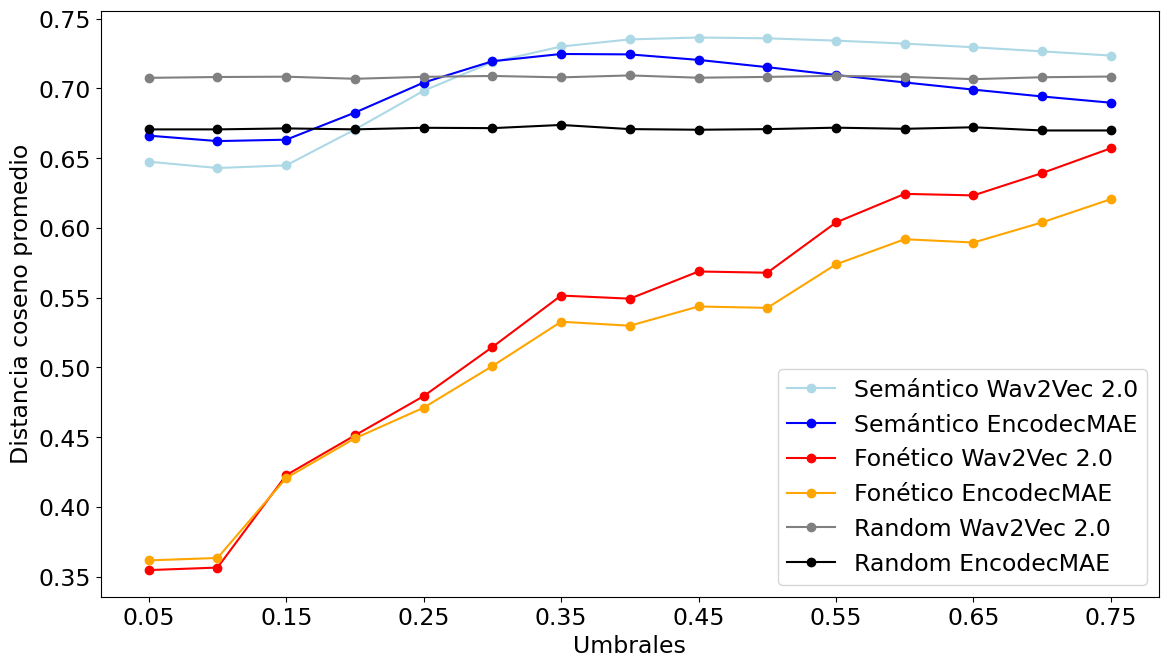

In [17]:
thresholds = np.arange(0.05, 0.8, 0.05)

plt.figure(figsize=(12, 7))
plt.rcParams.update({'font.size': 17}) 

plt.plot(thresholds, ds_vecinos_mean_w2v, marker='o', color='lightblue', label='Semántico Wav2Vec 2.0')
plt.plot(thresholds, ds_vecinos_mean_ec, marker='o', color='blue', label='Semántico EncodecMAE')
plt.plot(thresholds, df_vecinos_mean_w2v, marker='o', color='red', label='Fonético Wav2Vec 2.0')
plt.plot(thresholds, df_vecinos_mean_ec, marker='o', color='orange', label='Fonético EncodecMAE')
plt.plot(thresholds, dr_vecinos_mean_w2v, marker='o', color='gray', label='Random Wav2Vec 2.0')
plt.plot(thresholds, dr_vecinos_mean_ec, marker='o', color='black', label='Random EncodecMAE')

plt.xlabel('Umbrales')
plt.ylabel('Distancia coseno promedio')
plt.legend()
plt.xticks(np.arange(0.05, 0.8, 0.1))  
plt.tight_layout()
plt.show()